## Resampling KDE - Code Recipe

[Original repository on GitHub](https://github.com/Hvass-Labs/Code-Recipes)

Original author is [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

## Introduction

Resample a Probability Density Function (PDF) estimator such as the Kernel Density Estimation (KDE) that has been fitted to some data. This is useful if you want to save and load the KDE without saving all the raw data. We also show how to draw random samples from a histogram.

## Google Colab

In [1]:
# Is this running in Google Colab?
if 'google.colab' in str(get_ipython()):
    # Install all the required Python packages.
    %pip install numpy scipy matplotlib

## Imports

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

## Config

In [4]:
# Plot size.
plt.rcParams["figure.figsize"] = (20, 5)

## Functions

In [5]:
def pdf_resample(x, estimator, num=100, num_taper=5):
    """
    Resample a Probability Density Function (PDF) using the given estimator.
    
    This returns 3 arrays of length `num` with equally spaced points for the
    `x` values, the PDF, and the Cumulative Distribution Function (CDF).
    
    This is used to "compress" estimators for the PDF and CDF for the data `x`,
    so they can easily be saved and loaded, and then used with the function
    `rand_from_cdf` to draw random samples from the CDF.

    :param x:
        Array with data that we want the PDF for.
    
    :param estimator:
        Object similar to SciPy's `gaussian_kde` that has a method `evaluate`
        used to estimate the PDF values for the data `x`.
    
    :param num:
        Int with the number of estimation points to use in the arrays.
    
    :param num_taper:
        Int with the number of estimation points on each end of the PDF,
        that will be used to taper off to zero. This is disabled if set to 0.

    :return:
        points: Array with evenly spaced points over `x`.
        pdf_values: Array with the PDF values evaluated at `points`.
        cdf_values: Array with the CDF values evaluated at `points`.
    """
    # Distance between points, adjusted for tapering.
    point_delta = (x.max() - x.min()) / (num - 2 * num_taper - 1)
    
    # Evenly spaced points spanning the x-values (plus tapering).
    points = np.linspace(start=x.min() - point_delta * num_taper,
                         stop=x.max() + point_delta * num_taper, num=num)

    # Estimate the PDF at the given points. This is usually the slowest part.
    pdf_values = estimator.evaluate(points)
    
    # Taper off both ends of the PDF so they end in zero.
    if num_taper > 0:
        pdf_values[0:num_taper] *= \
            np.linspace(start=0.0, stop=1.0, num=num_taper)
        
        pdf_values[-num_taper:] *= \
            np.linspace(start=1.0, stop=0.0, num=num_taper)

    # Normalize the PDF values so they sum to 1.
    pdf_values /= pdf_values.sum()

    # Normalize CDF so it starts at 0.0 and ends at 1.0
    cdf_values = np.cumsum(pdf_values)
    cdf_values -= cdf_values[0]
    cdf_values /= cdf_values[-1]

    return points, pdf_values, cdf_values

In [6]:
def pdf_from_kde(x, kde_args=dict(), **kwargs):
    """
    Resample a Probability Density Function (PDF) from a Gaussian KDE.
    
    Time-usage is around 140 milli-sec when `len(x)=100000` and `num=100`,
    but it depends on the contents of `x` and can be faster or slower.

    :param x: Array with the data that we want the PDF for.
    :param kde_args: Dict with keyword-args passed to SciPy's `gaussian_kde`.
    :param kwargs: Extra keyword-args passed to function `pdf_resample`.
    :return: Same as the function `pdf_resample`.
    """
    # Create a Gaussian KDE for estimating the PDF of the input data.
    estimator = gaussian_kde(x, **kde_args)

    # Resample the KDE estimator.
    return pdf_resample(x=x, estimator=estimator, **kwargs)

In [7]:
def rand_from_cdf(rng, cdf_points, cdf_values, size):
    """
    Generate random numbers using a Cumulative Distribution Function (CDF),
    which is estimated using linear interpolation from the input arrays.

    This uses Inverse Transform Sampling of the CDF:
    https://en.wikipedia.org/wiki/Inverse_transform_sampling

    Time-usage is around 5 milli-sec when `size=100000`.

    :param rng: Instance of `numpy.random.default_rng`.
    :param cdf_points: Sorted array of data-points where the CDF is estimated.
    :param cdf_values: Array with the CDF-values corresponding to `cdf_points`.
    :param size: Shape of the output array.
    :return: Array with random numbers drawn from the given CDF.
    """
    # Draw random uniform numbers from [0,1) used in the "reverse-lookup".
    x = rng.uniform(0, 1, size=size)

    # Get the actual random values by a "reverse-lookup" of the CDF-values.
    # Note how points and values are switched in the interpolation function.
    values = np.interp(x=x, xp=cdf_values, fp=cdf_points)
    
    return values

In [8]:
def rand_from_hist(rng, hist, bin_edges, size, uniform=True):
    """
    Generate random numbers from a histogram, using the two arrays returned by
    NumPy's `histogram` function.

    Time-usage is around 5 milli-sec when `size=100000` and `uniform=False`,
    and around 8 milli-sec when `uniform=True`.

    :param rng:
        Instance of `numpy.random.default_rng`.
    
    :param hist:
        Array with values for the histogram (both freq and density are valid).
        This array is returned by NumPy's `histogram` function.
        
    :param bin_edges:
        Array with edges for the histogram-bins.
        This array is returned by NumPy's `histogram` function.

    :param size:
        Shape of the output array.

    :param uniform:
        Boolean whether to draw random uniform samples from each bin (True),
        or simply use the mid-points of the randomly chosen bins (False).

    :return:
        Array with random numbers drawn from the histogram.
    """
    # Normalize the histogram values so they sum to 1.
    p = hist / hist.sum()
    
    # Array of random indices for selecting histogram bins.
    index = rng.choice(len(p), p=p, size=size)

    if uniform:
        # Array of random uniform values, sampled between the bin-edges for
        # the randomly selected bins.
        values = rng.uniform(low=bin_edges[index], high=bin_edges[index+1])
    else:
        # Calculate mid-points for all the bins.
        midpoints = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # Lookup mid-points using the random bin index.
        values = midpoints[index]

    return values

## Test

In [9]:
# Random Number Generator (RNG).
rng = np.random.default_rng(seed=1234)

# Arrays with random values from different normal distributions.
x1 = rng.normal(loc=-0.05, scale=0.01, size=25000)
x2 = rng.normal(loc=0.02, scale=0.02, size=25000)
x3 = rng.normal(loc=0.075, scale=0.03, size=25000)
x4 = rng.normal(loc=0.12, scale=0.001, size=25000)

# Combine the arrays with random values.
x = np.concatenate([x1, x2, x3, x4])

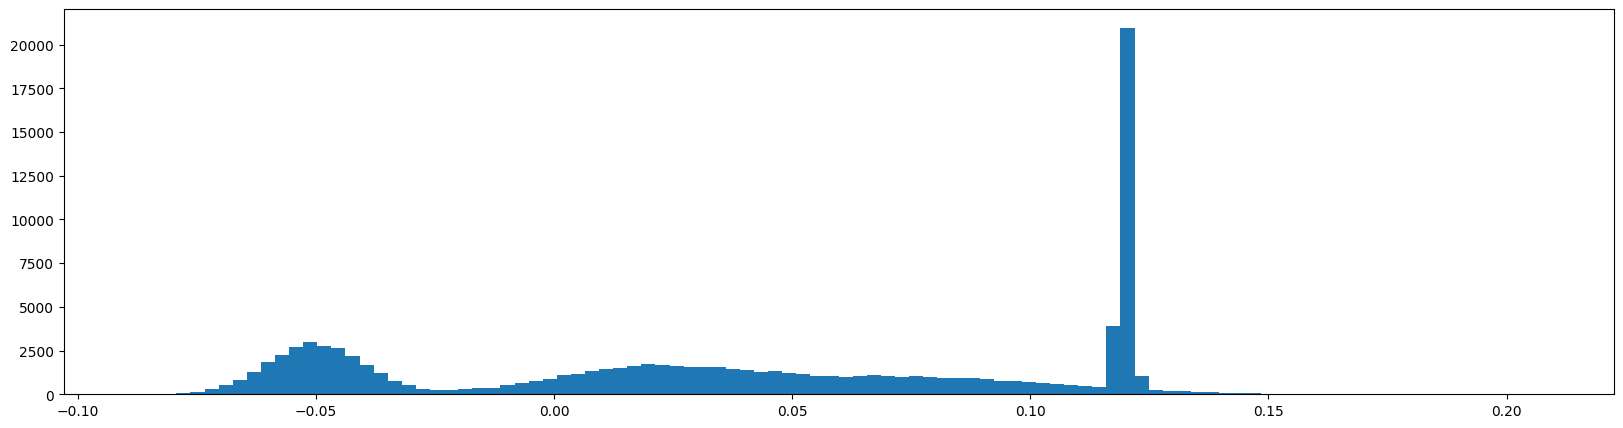

In [10]:
# Plot histogram of the random data.
plt.hist(x, bins=100);

In [11]:
# Number of points in the histogram and KDE resampling.
num = 100

In [12]:
# Compute histogram of the random data. You can save these arrays
# and load them later for use with the function `rand_from_hist`.
hist, bin_edges = np.histogram(x, bins=num, density=True)

In [13]:
# Compute KDE of the random data and resample it. You can save these
# arrays and load them later for use with the function `rand_from_cdf`.
kde_points, kde_pdf_values, kde_cdf_values = pdf_from_kde(x=x, num=num, num_taper=10)

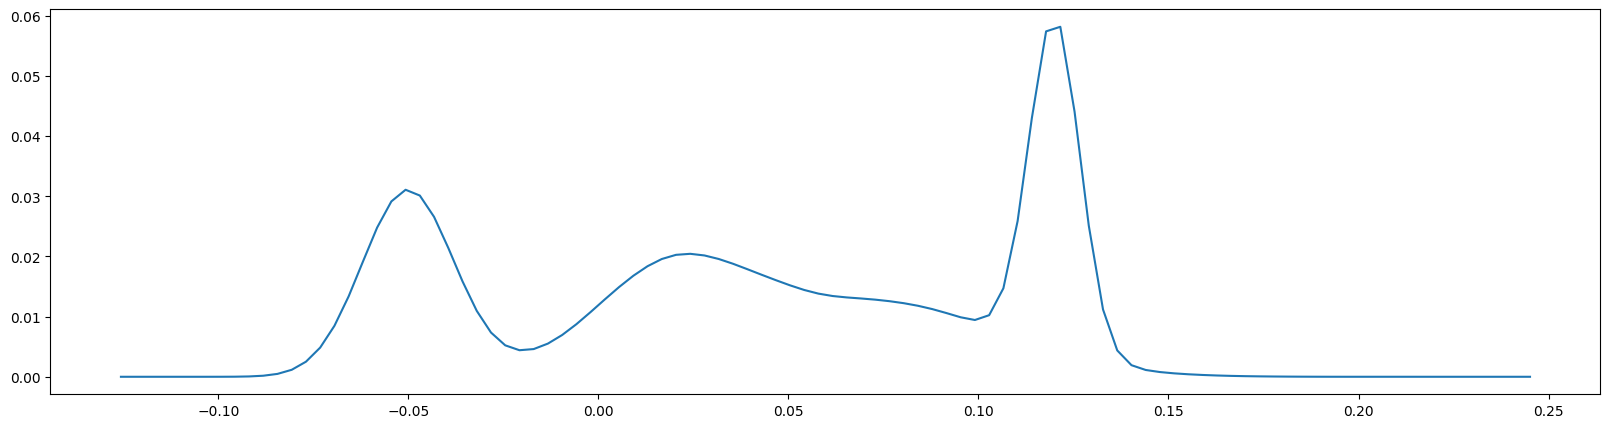

In [14]:
# Plot the resampled KDE using linear interpolation of the points.
plt.plot(kde_points, kde_pdf_values);

In [15]:
# Size of random sample from the resampled KDE and histogram.
sample_size = 100000

In [16]:
# Draw random samples using the resampled KDE.
kde_sample = rand_from_cdf(rng=rng, cdf_points=kde_points,
                           cdf_values=kde_cdf_values, size=sample_size)

In [17]:
# Draw random samples from the saved histogram, using uniform sampling of bins.
hist_sample1 = rand_from_hist(rng=rng, hist=hist, bin_edges=bin_edges,
                              size=sample_size, uniform=True)

In [18]:
# Draw random samples from the saved histogram, using mid-points of the bins.
hist_sample2 = rand_from_hist(rng=rng, hist=hist, bin_edges=bin_edges,
                              size=sample_size, uniform=False)

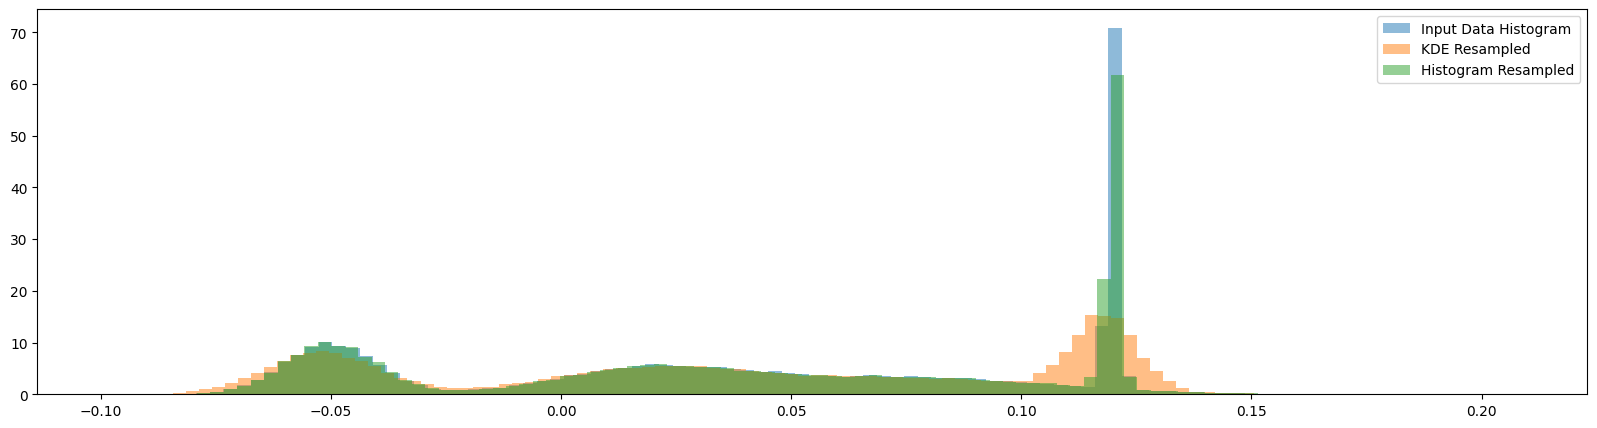

In [19]:
# Plot histogram of input data.
plt.hist(x, bins=100, alpha=0.5, label='Input Data Histogram', density=True);

# Plot histogram of random sample from the resampled KDE.
plt.hist(kde_sample, bins=100, alpha=0.5, label='KDE Resampled', density=True);

# Plot histogram of random sample from the original histogram. Uniform sampling.
plt.hist(hist_sample1, bins=100, alpha=0.5, label='Histogram Resampled', density=True);

# Show legend on plot.
plt.legend();

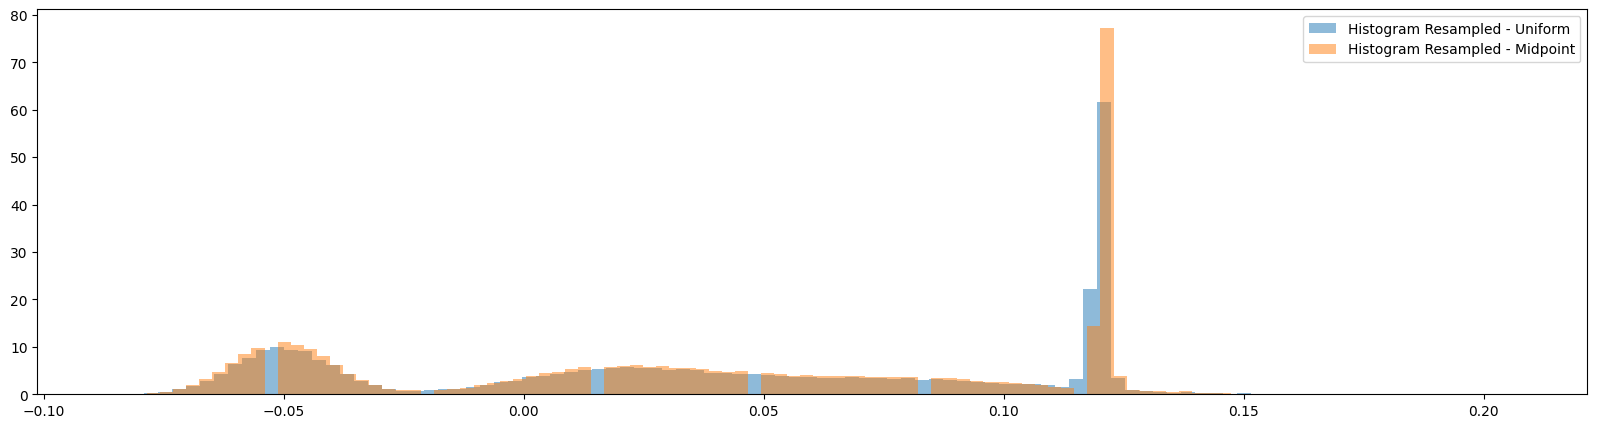

In [20]:
# Plot histogram of random sample from the original histogram. Uniform sampling.
plt.hist(hist_sample1, bins=100, alpha=0.5,
         label='Histogram Resampled - Uniform', density=True);

# Plot histogram of random sample from the original histogram. Mid-point sampling.
# NOTE: There may be empty bins in this histogram. This is not a bug! It is because
# the sampled mid-points are discrete, and they are put into new discrete histogram
# bins, so they sometimes fall into the neighouring bins and leave some bins empty.
# This is a phenomenon commonly known as "aliasing" in Digital Signal Processing.
# Try and change the number of bins `num` in the original histogram, and/or change
# the arg `bins` to this plotting-function e.g. to `bins=300`.
plt.hist(hist_sample2, bins=100, alpha=0.5,
         label='Histogram Resampled - Midpoint', density=True);

# Show legend on plot.
plt.legend();

## License (MIT)

This is published under the [MIT License](https://github.com/Hvass-Labs/Code-Recipes/blob/main/LICENSE) which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/Hvass-Labs/Code-Recipes).